In [36]:
import random
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import * 
import warnings
warnings.filterwarnings(action='ignore') 

In [37]:
seed=42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [65]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
building_info = pd.read_csv('./building_info.csv')

In [66]:
train_df.drop('num_date_time', axis = 1, inplace=True)
test_df.drop('num_date_time', axis = 1, inplace=True)

In [67]:
# Merge training data with building info
train_df = pd.merge(train_df, building_info, how='left', on='건물번호')
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# date time feature 생성
train_df['시'] = train_df['일시'].dt.hour
train_df['일'] = train_df['일시'].dt.day
train_df['월'] = train_df['일시'].dt.month
train_df['연도'] = train_df['일시'].dt.year

In [7]:
train_df['시'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [8]:
train_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,연도
0,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.0,39570.0,-,-,-,0,1,6,2022
1,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.0,39570.0,-,-,-,1,1,6,2022
2,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.0,39570.0,-,-,-,2,1,6,2022
3,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.0,39570.0,-,-,-,3,1,6,2022
4,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.0,39570.0,-,-,-,4,1,6,2022


In [68]:
# Sort the training data by '일시'
train_df.sort_values('일시', inplace=True)

# Calculate the average '풍속(m/s)'
average_wind_speed = train_df['풍속(m/s)'].mean()

# Fill the missing values in '풍속(m/s)' with the average wind speed
train_df['풍속(m/s)'].fillna(average_wind_speed, inplace=True)

In [69]:
# Forward and backward fill '습도(%)' for each hour
train_df['습도(%)'] = train_df.groupby('시')['습도(%)'].fillna(method='ffill').fillna(method='bfill')

# Check the number of missing values in '습도(%)' after filling
missing_humidity_after_filling = train_df['습도(%)'].isnull().sum()

# Fill the missing values in '강수량(mm)' with 0
train_df['강수량(mm)'].fillna(0, inplace=True)

In [43]:
train_df.isna().sum()

건물번호                0
일시                  0
기온(C)               0
강수량(mm)             0
풍속(m/s)             0
습도(%)               0
일조(hr)          75182
일사(MJ/m2)       87913
전력소비량(kWh)          0
건물유형                0
연면적(m2)             0
냉방면적(m2)            0
태양광용량(kW)           0
ESS저장용량(kWh)        0
PCS용량(kW)           0
시                   0
일                   0
월                   0
연도                  0
dtype: int64

In [70]:
# Drop '일조(hr)' and '일사(MJ/m2)' from the training data
train_df.drop(['일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)

In [71]:
train_df.isna().sum()

건물번호            0
일시              0
기온(C)           0
강수량(mm)         0
풍속(m/s)         0
습도(%)           0
전력소비량(kWh)      0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
시               0
일               0
월               0
연도              0
dtype: int64

In [72]:
train_df.drop('연도', axis = 1, inplace=True)
#train_df.reset_index(drop=True, inplace=True)

In [47]:
train_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,2022-06-01,18.6,0.0,0.9,42.0,1085.28,건물기타,110634.000,39570.00,-,-,-,0,1,6
142800,71,2022-06-01,18.5,0.0,1.9,38.0,1384.56,연구소,90896.000,44536.00,65,3100,800,0,1,6
140760,70,2022-06-01,18.5,0.0,1.9,38.0,3237.88,연구소,141014.000,120000.00,28.44,-,-,0,1,6
138720,69,2022-06-01,18.6,0.0,0.9,42.0,3269.10,연구소,139928.730,111183.19,14.4,-,-,0,1,6
136680,68,2022-06-01,18.6,0.0,0.9,42.0,1540.20,아파트,389395.928,0.00,-,-,-,0,1,6


In [73]:
train_df.reset_index(drop=True, inplace=True)

In [49]:
train_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,2022-06-01,18.6,0.0,0.9,42.0,1085.28,건물기타,110634.000,39570.00,-,-,-,0,1,6
1,71,2022-06-01,18.5,0.0,1.9,38.0,1384.56,연구소,90896.000,44536.00,65,3100,800,0,1,6
2,70,2022-06-01,18.5,0.0,1.9,38.0,3237.88,연구소,141014.000,120000.00,28.44,-,-,0,1,6
3,69,2022-06-01,18.6,0.0,0.9,42.0,3269.10,연구소,139928.730,111183.19,14.4,-,-,0,1,6
4,68,2022-06-01,18.6,0.0,0.9,42.0,1540.20,아파트,389395.928,0.00,-,-,-,0,1,6


In [74]:
# Merge training data with building info
test_df = pd.merge(test_df, building_info, how='left', on='건물번호')
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# date time feature 생성
test_df['시'] = test_df['일시'].dt.hour
test_df['일'] = test_df['일시'].dt.day
test_df['월'] = test_df['일시'].dt.month
test_df['연도'] = test_df['일시'].dt.year

In [19]:
test_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,연도
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,-,-,-,0,25,8,2022
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,-,-,-,1,25,8,2022
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,-,-,-,2,25,8,2022
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,-,-,-,3,25,8,2022
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,-,-,-,4,25,8,2022


In [75]:
train_df.drop('일시', axis=1,inplace=True)

In [76]:
test_df.drop('연도', axis = 1, inplace=True)
test_df.drop('일시', axis = 1, inplace=True)

In [22]:
train_df.columns

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '건물유형',
       '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '시',
       '일', '월'],
      dtype='object')

In [23]:
test_df.columns

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '건물유형', '연면적(m2)',
       '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '시', '일', '월'],
      dtype='object')

In [53]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,-,-,-,0,25,8
1,1,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,-,-,-,1,25,8
2,1,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,-,-,-,2,25,8
3,1,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,-,-,-,3,25,8
4,1,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,-,-,-,4,25,8


In [77]:
# Handle missing values
train_df.fillna({'태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# # Convert categorical column '건물유형' into numerical values using one-hot encoding
# train_df = pd.get_dummies(train_df, columns=['건물유형'])
le = LabelEncoder()

# Apply LabelEncoder to '건물유형' column
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])
test_df['건물유형'] = le.transform(test_df['건물유형'])
# Create new features
train_df['냉방면적비율'] = train_df['냉방면적(m2)'] / train_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
train_df['기온습도'] = train_df['기온(C)'] * train_df['습도(%)']  # The interaction between temperature and humidity

train_df.head()


,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,18.6,0.0,0.9,42.0,1085.28,0,110634.000,39570.00,-,-,-,0,1,6,0.357666,781.2
1,71,18.5,0.0,1.9,38.0,1384.56,8,90896.000,44536.00,65,3100,800,0,1,6,0.489967,703.0
2,70,18.5,0.0,1.9,38.0,3237.88,8,141014.000,120000.00,28.44,-,-,0,1,6,0.850979,703.0
3,69,18.6,0.0,0.9,42.0,3269.10,8,139928.730,111183.19,14.4,-,-,0,1,6,0.794570,781.2
4,68,18.6,0.0,0.9,42.0,1540.20,7,389395.928,0.00,-,-,-,0,1,6,0.000000,781.2


In [78]:
train_df.drop('냉방면적(m2)', axis=1,inplace=True)
train_df.drop('연면적(m2)', axis=1,inplace=True)
train_df.drop('기온(C)', axis=1,inplace=True)
train_df.drop('습도(%)', axis=1,inplace=True)

In [79]:
test_df.fillna({'강수량(mm)': 0, '일조(hr)': 0, '일사(MJ/m2)': 0, '태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# Create new features
test_df['냉방면적비율'] = test_df['냉방면적(m2)'] / test_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
test_df['기온습도'] = test_df['기온(C)'] * test_df['습도(%)']  # The interaction between temperature and humidity

test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,23.5,0.0,2.2,72,0,110634.0,39570.0,-,-,-,0,25,8,0.357666,1692.0
1,1,23.0,0.0,0.9,72,0,110634.0,39570.0,-,-,-,1,25,8,0.357666,1656.0
2,1,22.7,0.0,1.5,75,0,110634.0,39570.0,-,-,-,2,25,8,0.357666,1702.5
3,1,22.1,0.0,1.3,78,0,110634.0,39570.0,-,-,-,3,25,8,0.357666,1723.8
4,1,21.8,0.0,1.0,77,0,110634.0,39570.0,-,-,-,4,25,8,0.357666,1678.6


In [80]:
test_df.drop('냉방면적(m2)', axis=1,inplace=True)
test_df.drop('연면적(m2)', axis=1,inplace=True)
test_df.drop('기온(C)', axis=1,inplace=True)
test_df.drop('습도(%)', axis=1,inplace=True)

In [81]:
import numpy as np

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
train_df.dtypes

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    test_df[col] = test_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
test_df.dtypes

건물번호              int64
강수량(mm)         float64
풍속(m/s)         float64
건물유형              int32
태양광용량(kW)       float64
ESS저장용량(kWh)    float64
PCS용량(kW)       float64
시                 int64
일                 int64
월                 int64
냉방면적비율          float64
기온습도            float64
dtype: object

In [29]:
train_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,18.6,0.0,0.9,42.0,1085.28,0,110634.000,39570.00,0.00,0.0,0.0,0,1,6,0.357666,781.2
1,71,18.5,0.0,1.9,38.0,1384.56,8,90896.000,44536.00,65.00,3100.0,800.0,0,1,6,0.489967,703.0
2,70,18.5,0.0,1.9,38.0,3237.88,8,141014.000,120000.00,28.44,0.0,0.0,0,1,6,0.850979,703.0
3,69,18.6,0.0,0.9,42.0,3269.10,8,139928.730,111183.19,14.40,0.0,0.0,0,1,6,0.794570,781.2
4,68,18.6,0.0,0.9,42.0,1540.20,7,389395.928,0.00,0.00,0.0,0.0,0,1,6,0.000000,781.2


In [30]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,23.5,0.0,2.2,72,0,110634.0,39570.0,0.0,0.0,0.0,0,25,8,0.357666,1692.0
1,1,23.0,0.0,0.9,72,0,110634.0,39570.0,0.0,0.0,0.0,1,25,8,0.357666,1656.0
2,1,22.7,0.0,1.5,75,0,110634.0,39570.0,0.0,0.0,0.0,2,25,8,0.357666,1702.5
3,1,22.1,0.0,1.3,78,0,110634.0,39570.0,0.0,0.0,0.0,3,25,8,0.357666,1723.8
4,1,21.8,0.0,1.0,77,0,110634.0,39570.0,0.0,0.0,0.0,4,25,8,0.357666,1678.6


In [82]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output


In [83]:
# Define features and target again after preprocessing
X = train_df.drop('전력소비량(kWh)', axis=1)
y = train_df['전력소비량(kWh)']
model = setup(X, target = y, session_id=seed )
# SMAPE를 pycaret 지표로 추가
from pycaret.regression import add_metric
add_metric('smape', 'SMAPE', smape, greater_is_better=False)

,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 13)"
4,Transformed data shape,"(204000, 13)"
5,Transformed train set shape,"(142800, 13)"
6,Transformed test set shape,"(61200, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


Name                                                       SMAPE
Display Name                                               SMAPE
Score Function            <function smape at 0x000002AC3185EAF0>
Scorer               make_scorer(smape, greater_is_better=False)
Target                                                      pred
Args                                                          {}
Greater is Better                                          False
Custom                                                      True
Name: smape, dtype: object

In [84]:
top5_models = compare_models(fold = 5, round = 3, sort = 'smape', n_select = 5)
top5_models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:51:39
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
rf,Random Forest Regressor,166.288,131691.180,362.820,0.978,0.139,0.082,7.492,17.726
et,Extra Trees Regressor,174.743,139519.136,373.488,0.977,0.146,0.087,7.865,13.282
dt,Decision Tree Regressor,188.024,236665.675,486.334,0.961,0.183,0.091,8.574,0.826
catboost,CatBoost Regressor,256.993,192813.932,439.052,0.968,0.204,0.143,13.110,9.528
xgboost,Extreme Gradient Boosting,255.451,188869.453,434.459,0.969,0.214,0.143,13.277,3.704
lightgbm,Light Gradient Boosting Machine,321.671,251052.635,501.014,0.958,0.237,0.188,16.389,1.106
gbr,Gradient Boosting Regressor,606.856,781532.219,884.010,0.870,0.402,0.377,28.920,4.914
knn,K Neighbors Regressor,892.468,2455964.900,1566.818,0.591,0.508,0.481,35.489,1.212
huber,Huber Regressor,1329.229,6155960.517,2480.719,-0.025,0.717,0.626,52.287,1.254
br,Bayesian Ridge,1396.330,5418634.000,2327.256,0.098,0.738,0.851,54.631,0.572


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

[RandomForestRegressor(n_jobs=-1, random_state=42),
 ExtraTreesRegressor(n_jobs=-1, random_state=42),
 DecisionTreeRegressor(random_state=42),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)]

In [ ]:
et = create_model('et',fold=10)

In [85]:
rf = create_model('rf', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,160.7288,122513.2911,350.0190,0.9802,0.1368,0.0805,7.3535
1,160.1223,125893.0652,354.8141,0.9787,0.1302,0.0775,7.1793
2,162.0832,126283.8771,355.3644,0.9798,0.1474,0.0801,7.3403
3,162.0335,131876.8125,363.1485,0.9791,0.1345,0.0783,7.1692
4,163.0266,127005.1855,356.3779,0.9770,0.1348,0.0800,7.3272
5,158.2541,117642.6030,342.9907,0.9799,0.1290,0.0770,7.1099
6,162.6318,129650.1099,360.0696,0.9785,0.1372,0.0811,7.3915
7,160.0060,130667.1291,361.4791,0.9801,0.1318,0.0780,7.2161
8,156.3943,114929.1815,339.0121,0.9806,0.1337,0.0779,7.1431


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
model_rf = tune_model(rf, fold=10, optimize = 'smape', choose_better = True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:34:14
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [86]:
final_model = finalize_model(rf) # 모델 선택

In [87]:
prediction = predict_model(final_model, data = test_df)
prediction.head()

,건물번호,강수량(mm),풍속(m/s),건물유형,태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도,prediction_label
0,1,0.0,2.2,0,0.0,0.0,0.0,0,25,8,0.357666,1692.000000,2124.575999
1,1,0.0,0.9,0,0.0,0.0,0.0,1,25,8,0.357666,1656.000000,2101.377579
2,1,0.0,1.5,0,0.0,0.0,0.0,2,25,8,0.357666,1702.500000,1999.046416
3,1,0.0,1.3,0,0.0,0.0,0.0,3,25,8,0.357666,1723.800049,1975.780806
4,1,0.0,1.0,0,0.0,0.0,0.0,4,25,8,0.357666,1678.599976,1932.940802


In [88]:
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = prediction['prediction_label']
submission

,num_date_time,answer
0,1_20220825 00,2124.575999
1,1_20220825 01,2101.377579
2,1_20220825 02,1999.046416
3,1_20220825 03,1975.780806
4,1_20220825 04,1932.940802
...,...,...
16795,100_20220831 19,1143.033604
16796,100_20220831 20,948.396006
16797,100_20220831 21,833.899195
16798,100_20220831 22,734.103607


In [89]:
submission.head()

,num_date_time,answer
0,1_20220825 00,2124.575999
1,1_20220825 01,2101.377579
2,1_20220825 02,1999.046416
3,1_20220825 03,1975.780806
4,1_20220825 04,1932.940802


In [90]:
submission.to_csv('./sample_submission.csv', index=False)

# XGBoost

In [99]:
from xgboost import XGBRegressor

# Create an instance of XGBRegressor
xgb = XGBRegressor()
# Fit the model to the training data
xgb.fit(X, y)

preds = xgb.predict(test_df)

submission = pd.read_csv('./sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [100]:
submission['answer'] = preds
submission

,num_date_time,answer
0,1_20220825 00,1993.957153
1,1_20220825 01,1886.646362
2,1_20220825 02,1726.210083
3,1_20220825 03,1749.005005
4,1_20220825 04,1750.335449
...,...,...
16795,100_20220831 19,931.303589
16796,100_20220831 20,895.451111
16797,100_20220831 21,845.433472
16798,100_20220831 22,681.605469


In [101]:
submission.to_csv('./sample_submission.csv', index=False)

In [25]:
train_df['건물유형'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [58]:
len(train_df)

204000

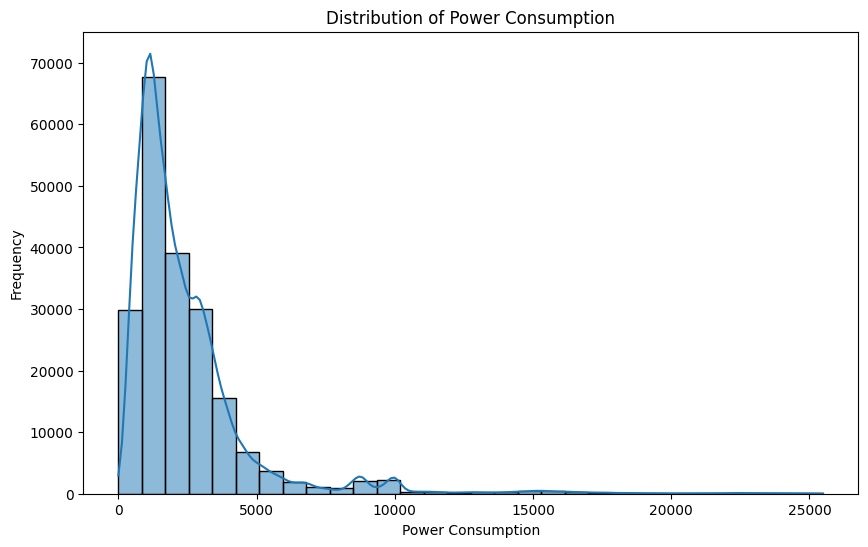

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_df['전력소비량(kWh)'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

In [53]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),시,일,월
0,1,23.5,0.0,2.2,72,0,25,8
1,1,23.0,0.0,0.9,72,1,25,8
2,1,22.7,0.0,1.5,75,2,25,8
3,1,22.1,0.0,1.3,78,3,25,8
4,1,21.8,0.0,1.0,77,4,25,8


In [7]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [8]:
building_info['건물유형'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

In [12]:
building_info.isnull().sum()

건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64

In [13]:
train_df.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [25]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].notna()).sum()

1

일조 데이터가 null이면서 일사 데이터가 null이 아닌 데이터는 한개뿐

In [26]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].isna()).sum()

75181

In [14]:
len(train_df)

204000

In [21]:
(train_df['건물번호'] >100).sum()

0

In [16]:
building_info['건물번호'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)